In [128]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import os
from glob import glob

In [129]:
path = 'arabidopsis/'

In [130]:
def loader(path):
    images = glob(os.path.join(path,'images/*'))
    masks = glob(os.path.join(path,'masks/*'))
    return images, masks

In [131]:
images, masks = loader(path=path)

In [132]:
len(images)

16

In [133]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (128, 128))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (128, 128))
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.float32)
    return x

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)

        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([128, 128, 3])
    masks.set_shape([128, 128, 1])

    return images, masks

def tf_dataset(x, y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [134]:
ath = 'arabidopsis/'
images, masks = loader(path)
print(f"Images: {len(images)} - Masks: {len(masks)}")

dataset = tf_dataset(images, masks)

Images: 16 - Masks: 16


In [135]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [136]:
def build_unet_model():
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [137]:
unet_model = build_unet_model()

In [138]:
unet_model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy",run_eagerly=True)

In [139]:
dataset.batch

<bound method DatasetV2.batch of <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>>

In [140]:
model_history = unet_model.fit(dataset,
                              epochs=4,
                              steps_per_epoch=1)

Epoch 1/4
1/1 [==============================] - 2s 2s/step - loss: 0.9095 - accuracy: 0.7091
Epoch 2/4
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 0.9423
Epoch 3/4
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 0.9446
Epoch 4/4
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 0.9574


In [145]:
from tensorflow.keras.preprocessing import image

img_path = 'AAE_0003.JPG'
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

pred_mask = unet_model.predict(dataset)

4/4 [==============================] - 4s 880ms/step


In [146]:
pred_mask

array([[[[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        ...,

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]]],


       [[[1., 0., 0.],
         [1., 0., 0.],
         [1., 

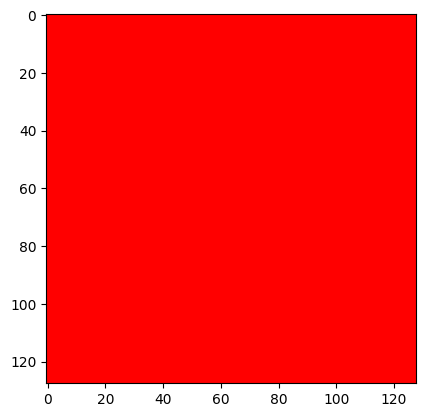

In [151]:
plt.imshow(pred_mask[1,:,:,:]*255)

In [148]:
pred_mask[:,:,:,:].shape

(16, 128, 128, 3)